In [2]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')

# TensorFlow Warning Suppression
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [4]:
df = pd.read_csv("international-airline-passengers.csv")

In [5]:
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [6]:
df.columns

Index(['Month', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')

When we examine the data, we observe that some of the variable names have a complex structure. In this case, let's perform a renaming process.

In [7]:
df.columns = ["Month" , "Passengers"]

In [8]:
df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [9]:
df.shape

(145, 2)

In [10]:
df.dtypes

Month          object
Passengers    float64
dtype: object

In [11]:
df.isnull().sum()    # missing data

Month         0
Passengers    1
dtype: int64

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


We need to remove the missing data in the last row from the dataset.

In [13]:
df = df[:144]

In [14]:
df.tail()

,Month,Passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


While examining the data, we noticed that the date variable is of type object. We need to correct this.

In [15]:
df["Month"] = pd.to_datetime(df["Month"])

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


The variable we will be focusing on is the 'passenger' variable. Therefore, let's set the 'month' variable as the index.

In [17]:
df.index = df["Month"]

In [18]:
df.head()

,Month,Passengers
Month,,
1949-01-01,1949-01-01,112.0
1949-02-01,1949-02-01,118.0
1949-03-01,1949-03-01,132.0
1949-04-01,1949-04-01,129.0
1949-05-01,1949-05-01,121.0


In [19]:
df.drop("Month", axis=1, inplace=True)

In [20]:
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [21]:
result_df = df.copy()    # keep the final version of the dataframe aside for evaluating the model results.

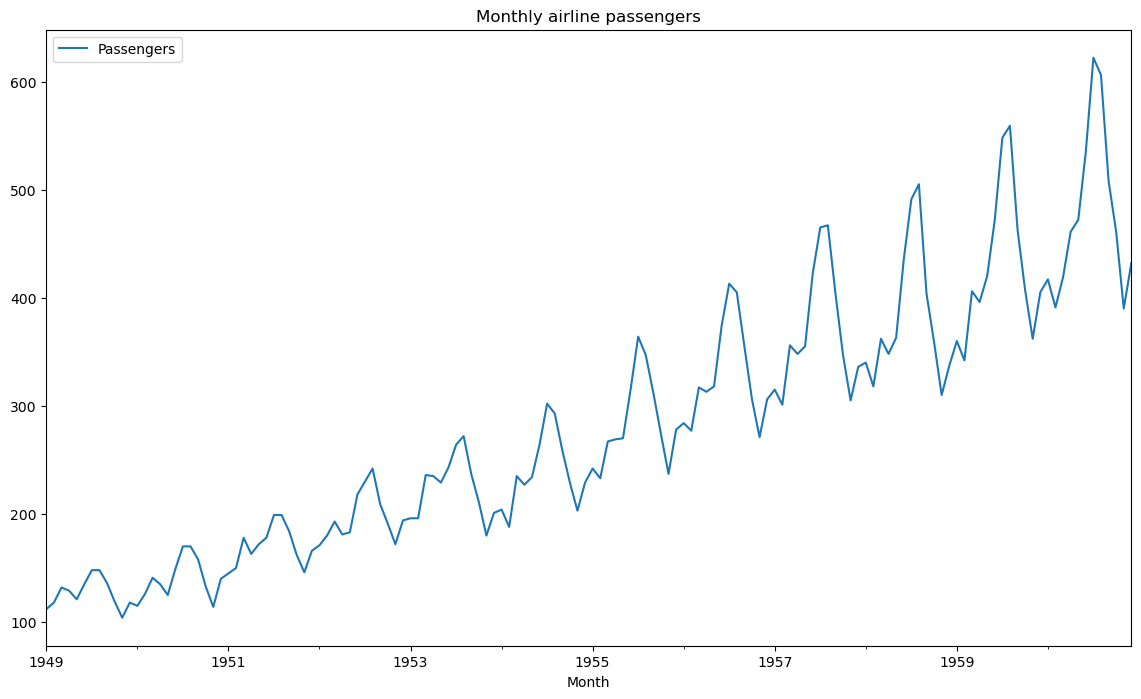

In [22]:
df.plot(figsize=(14, 8), title='Monthly airline passengers');

"Data is in the form of a pandas dataframe. Before starting the modeling process, we need to convert it into a numpy array."

In [23]:
data = df["Passengers"].values

In [24]:
type(data)

numpy.ndarray

In [25]:
type(data[0])     #float32 or float64 

numpy.float64

In [26]:
data = data.astype('float32')

In [27]:
type(data[0])

numpy.float32

Before feeding the data into the model, dimension adjustment should be done.

In [28]:
data.shape

(144,)

In [29]:
data = data.reshape(-1,1)

In [30]:
data.shape     #this means 144 observations in a single dimension.

(144, 1)

If we were performing a regression task, we could have used the train_test_split method from the scikit-learn library. However, since our data is time series data, and the train_test_split method splits the data randomly into train and test sets, we are not using it. 
If we split the data randomly, we may lose the continuity that is crucial for time series analysis. Therefore, in time series problems, the train-test split should be done in a controlled manner.

In [31]:
def split_data(dataframe, test_size):
    position = int(round(len(dataframe) * (1 - test_size)))
    train = dataframe[:position]
    test = dataframe[position:]
    return train, test, position

In [32]:
train, test, position = split_data(data, 0.33)

In [33]:
print(train.shape, test.shape)

(96, 1) (48, 1)


In gradient descent-based problems, we perform a standardization process on the independent variables before sending them to the model. The purpose is to optimize the process more quickly, aiming for speed and performance improvements.

The reason we scale the dataset separately as train and test rather than as a whole is that, after splitting the data, some values in the training set may point to values in the test set.

In [34]:
scaler_train = MinMaxScaler(feature_range=(0, 1))

In [35]:
train = scaler_train.fit_transform(train)

In [36]:
scaler_test = MinMaxScaler(feature_range=(0, 1))

In [37]:
test = scaler_test.fit_transform(test)

In [38]:
train[0:5]

array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [39]:
test[0:5]

array([[0.04361373],
       [0.        ],
       [0.17133951],
       [0.1464175 ],
       [0.16822433]], dtype=float32)

We need to determine a feature for the model. In time series-related problems, we need to specify a period. For example, we will define a monthly period for our own data. We will write a function for this. This means that the predictions will be influenced by the data from the previous month.

In [40]:
def create_features(data, lookback):
    X, Y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        Y.append(data[i, 0])

    return np.array(X), np.array(Y)

In [41]:
lookback = 1    #example

In [42]:
# Train Veri Seti
X_train, y_train = create_features(train, lookback)

In [43]:
# Test Veri Seti
X_test, y_test = create_features(test, lookback)

In [44]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)    # it seems that there is a decrease because lookback is set to 1.

(95, 1) (95,) (47, 1) (47,)


The data to be sent to the RNN needs to be three-dimensional. We will use the reshape method to make the data three-dimensional.

In [45]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [47]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(95, 1, 1) (95, 1) (47, 1, 1) (47, 1)


In [48]:
#modeling
model = Sequential()
model.add(SimpleRNN(units=50,   # units represent neurons.
                    activation='relu',
                    input_shape=(X_train.shape[1], lookback)))
model.add(Dropout(0.2))   # to prevent overfitting
model.add(Dense(1)) # output layer consisting of 1 neuron

In a classification problem, the number of neurons in the output layer is expected to be equal to the number of classes. In our problem, we are not expecting a class value in the output, but rather a numerical prediction value similar to regression. We will be expecting a single numerical value from a single neuron.

In [50]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 50)             │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# optimization and adjustment of evaluation metrics
model.compile(loss='mean_squared_error', optimizer='adam')

In [53]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min'),
             ModelCheckpoint(filepath='mymodel.keras', monitor='val_loss', mode='min',
                             save_best_only=True, save_weights_only=False, verbose=1)]

Up to a certain point, the loss decreases together in both the training and test sets. However, beyond that point, while the loss continues to decrease in the training set, it stops decreasing in the test set. Early stopping allows us to say 'stop' if there is no further decrease or progress in the validation set after a certain point.
ModelCheckpoint is used to save the model.

In [54]:
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=50,
                    batch_size=1,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks,
                    shuffle=False)

Epoch 1/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 35s 382ms/step - loss: 0.0026
Epoch 1: val_loss improved from inf to 0.03155, saving model to mymodel.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0249 - val_loss: 0.0316
Epoch 2/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0397
Epoch 2: val_loss improved from 0.03155 to 0.02887, saving model to mymodel.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - loss: 0.0298 - val_loss: 0.0289
Epoch 3/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0475
Epoch 3: val_loss improved from 0.02887 to 0.02635, saving model to mymodel.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - loss: 0.0282 - val_loss: 0.0264
Epoch 4/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0290
Epoch 4: val_loss improved from 0.02635 to 0.02492, saving model to mymodel.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - loss: 0.0241 - val_loss: 0.0249
Epoch 5/50
 1/95 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0229
Epoch 5: val_loss improved from 0.02492 to 0.02227

Early stopping occurred at the 12th epoch. Thus, overfitting was prevented.

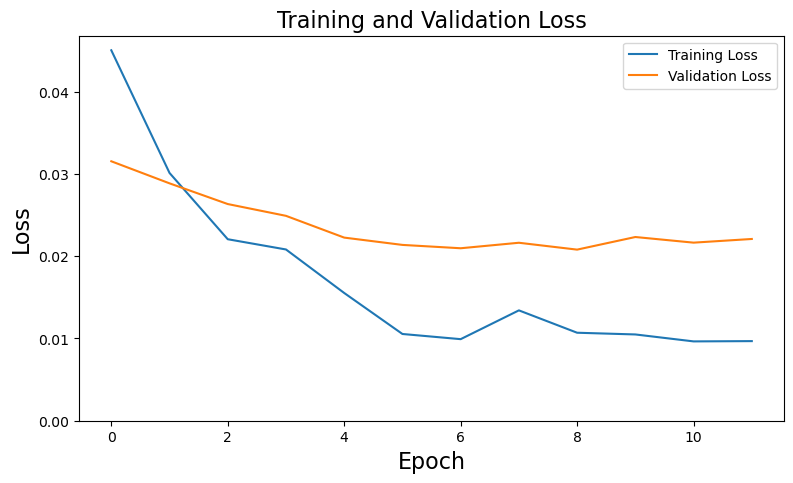

In [55]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()

In [56]:
#evaluation
loss = model.evaluate(X_test, y_test, batch_size=1)
print("\nTest loss: %.1f%%" % (100.0 * loss))

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step - loss: 0.0172

Test loss: 2.2%


In [57]:
train_predict = model.predict(X_train)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [58]:
test_predict = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [59]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [60]:
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

We are reversing the scaled values to better observe the prediction values.

In [61]:
# RMSE value for the training dataset
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))

In [62]:
# RMSE value for the test dataset
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

When we take the square root of the MSE, we obtain the RMSE value.

In [63]:
train_prediction_df = result_df[lookback:position]  # the first observation will not have a preceding data point, so it cannot be predicted.

In [64]:
train_prediction_df["Predicted"] = train_predict

In [65]:
train_prediction_df.head()

,Passengers,Predicted
Month,,
1949-02-01,118.0,134.248917
1949-03-01,132.0,137.425858
1949-04-01,129.0,149.046265
1949-05-01,121.0,146.250443
1949-06-01,135.0,139.433914


In [66]:
test_prediction_df = result_df[position+lookback:]

In [67]:
test_prediction_df["Predicted"] = test_predict

In [68]:
test_prediction_df.head()

,Passengers,Predicted
Month,,
1957-02-01,301.0,335.372742
1957-03-01,356.0,329.114532
1957-04-01,348.0,371.944611
1957-05-01,355.0,364.489136
1957-06-01,422.0,371.012695


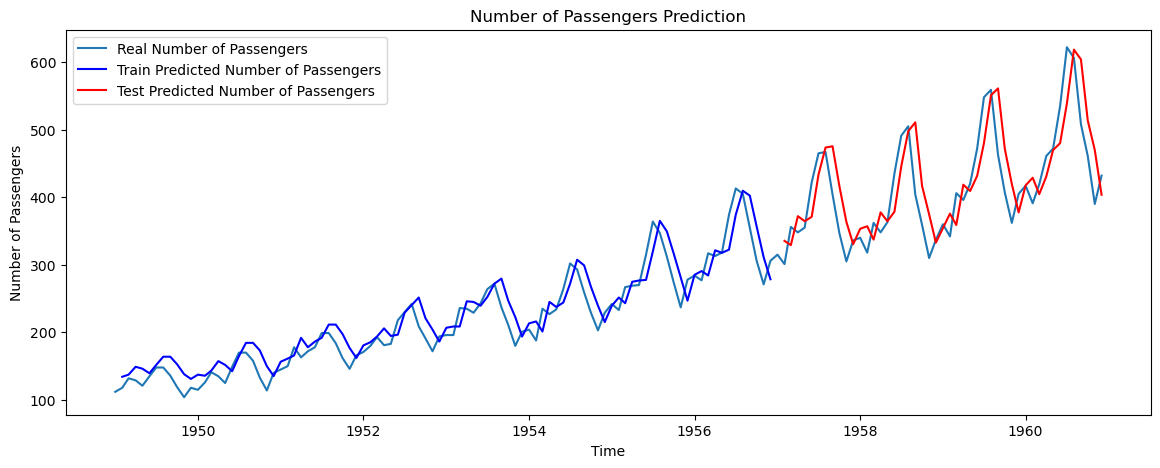

In [69]:
# Visualizing Train and Test Predictions Separately
plt.figure(figsize=(14,5))
plt.plot(result_df, label='Real Number of Passengers')
plt.plot(train_prediction_df["Predicted"], color='blue', label='Train Predicted Number of Passengers')
plt.plot(test_prediction_df["Predicted"], color='red', label='Test Predicted Number of Passengers')
plt.title('Number of Passengers Prediction')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

The MSE value appeared small due to the standardized values. Therefore, we reversed the scaled values and visualized the predictions and actual values for the train and test sets.